# 0. Imports

## 0.1. Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-white')
import seaborn as sns
import scikitplot as skplt
import numpy as np
import pickle
from flask import Flask, request
import json

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, TargetEncoder, PowerTransformer, RobustScaler, QuantileTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression

from boruta import BorutaPy

## 0.2. Helper Functions

In [2]:
# Save intermediate dataset
def save_interim(dataframe, file_name):
   dataframe.to_csv('../data/interim/'+file_name+'.zip', index=False, compression= 'zip')

# Load intermediate dataset
def load_interim(file_name):
   return pd.read_csv('../data/interim/'+file_name, compression='zip')

# Seed for Random State
seed = 42

## 0.2. Loading Dataset

In [3]:
df_raw = pd.read_csv('/home/ezequiel/Documentos/Comunidade_DS/health_insurance_cross_sell/data/raw/train.csv')
df1 = df_raw.copy()

In [4]:
df1.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [5]:
df1.columns = df1.columns.str.lower()

In [6]:
df1.columns

Index(['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage', 'response'],
      dtype='object')

In [7]:
save_interim(df1, 'df1.csv')

# 1. Data Description

Columns description:

* **id**                      Unique ID for the customer  
* **Gender**                  Gender of the customer  
* **Age**                     Age of the customer  
* **Driving_License**         0 : Customer does not have DL, 1 : Customer already has DL  
* **Region_Code** 	        Unique code for the region of the customer  
* **Previously_Insured**	    1 : Customer already has Vehicle Insurance, 0 : Customer doesn't have Vehicle Insurance  
* **Vehicle_Age** 	        Age of the Vehicle  
* **Vehicle_Damage** 	        1 : Customer got his/her vehicle damaged in the past. 0 : Customer didn't get his/her vehicle damaged in the past.  
* **Annual_Premium** 	        The amount customer needs to pay as premium in the year  
* **Policy_Sales_Channel** 	Anonymized Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc.  
* **Vintage** 	            Number of Days which customer has been associated with the company  
* **Response** 	            1 : Customer is interested, 0 : Customer is not interested

Currency: Idian Rupee (Rs)

## 1.1. Data Dimension

In [8]:
print(f'Number of rows: {df1.shape[0]}')
print(f'Number of columns: {df1.shape[1]}')

Number of rows: 381109
Number of columns: 12


## 1.2. Data Types

In [9]:
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

In [10]:
# Changing driving_license, previously_insured, vehicle_damage and response to a less cost memory data type, for example, int32
df1['driving_license'] = df1['driving_license'].astype('int8')
df1['previously_insured'] = df1['previously_insured'].astype('int8')
df1['response'] = df1['response'].astype('int8')

In [11]:
save_interim(df1, 'df1.csv')

## 1.3. Check NA

In [12]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   gender                381109 non-null  object 
 2   age                   381109 non-null  int64  
 3   driving_license       381109 non-null  int8   
 4   region_code           381109 non-null  float64
 5   previously_insured    381109 non-null  int8   
 6   vehicle_age           381109 non-null  object 
 7   vehicle_damage        381109 non-null  object 
 8   annual_premium        381109 non-null  float64
 9   policy_sales_channel  381109 non-null  float64
 10  vintage               381109 non-null  int64  
 11  response              381109 non-null  int8   
dtypes: float64(3), int64(3), int8(3), object(3)
memory usage: 27.3+ MB


## 1.4. Data Description

### 1.4.1. Categorical variables

In [13]:
cat_attributes = df1.select_dtypes(include='object')
cat_attributes.columns

Index(['gender', 'vehicle_age', 'vehicle_damage'], dtype='object')

In [14]:
cat_attributes.describe()

,gender,vehicle_age,vehicle_damage
count,381109,381109,381109
unique,2,3,2
top,Male,1-2 Year,Yes
freq,206089,200316,192413


In [15]:
cat_attributes.apply(pd.Series.value_counts)

,gender,vehicle_age,vehicle_damage
1-2 Year,NaN,200316.0,NaN
< 1 Year,NaN,164786.0,NaN
> 2 Years,NaN,16007.0,NaN
Female,175020.0,NaN,NaN
Male,206089.0,NaN,NaN
No,NaN,NaN,188696.0
Yes,NaN,NaN,192413.0


**Summary**
- Male is the top gender
- Top vehicle age is between 1 and 2 years
- Most of cars have already had damaged

### 1.4.2. Numerical variables

In [16]:
num_attributes = df1.select_dtypes(exclude='object')
df_describe = num_attributes.describe().T
df_describe['kurtosis'] = num_attributes.kurtosis()
df_describe['skewness'] = num_attributes.skew()

In [17]:
df_describe

,count,mean,std,min,25%,50%,75%,max,kurtosis,skewness
id,381109.0,190555.000000,110016.836208,1.0,95278.0,190555.0,285832.0,381109.0,-1.200000,9.443274e-16
age,381109.0,38.822584,15.511611,20.0,25.0,36.0,49.0,85.0,-0.565655,6.725390e-01
driving_license,381109.0,0.997869,0.046110,0.0,1.0,1.0,1.0,1.0,464.354302,-2.159518e+01
region_code,381109.0,26.388807,13.229888,0.0,15.0,28.0,35.0,52.0,-0.867857,-1.152664e-01
previously_insured,381109.0,0.458210,0.498251,0.0,0.0,0.0,1.0,1.0,-1.971871,1.677471e-01
annual_premium,381109.0,30564.389581,17213.155057,2630.0,24405.0,31669.0,39400.0,540165.0,34.004569,1.766087e+00
policy_sales_channel,381109.0,112.034295,54.203995,1.0,29.0,133.0,152.0,163.0,-0.970810,-9.000081e-01
vintage,381109.0,154.347397,83.671304,10.0,82.0,154.0,227.0,299.0,-1.200688,3.029517e-03
response,381109.0,0.122563,0.327936,0.0,0.0,0.0,0.0,1.0,3.298788,2.301906e+00


**Summary**
- Some numerical variables are representing cattegorical variables:
    - driving license
    - previously insured
    - response
- Variable representing numerical variables:
    - age
    - annual premium
    - vintage
    - region code?
    - policy sales channel?

<Axes: xlabel='vintage', ylabel='Count'>

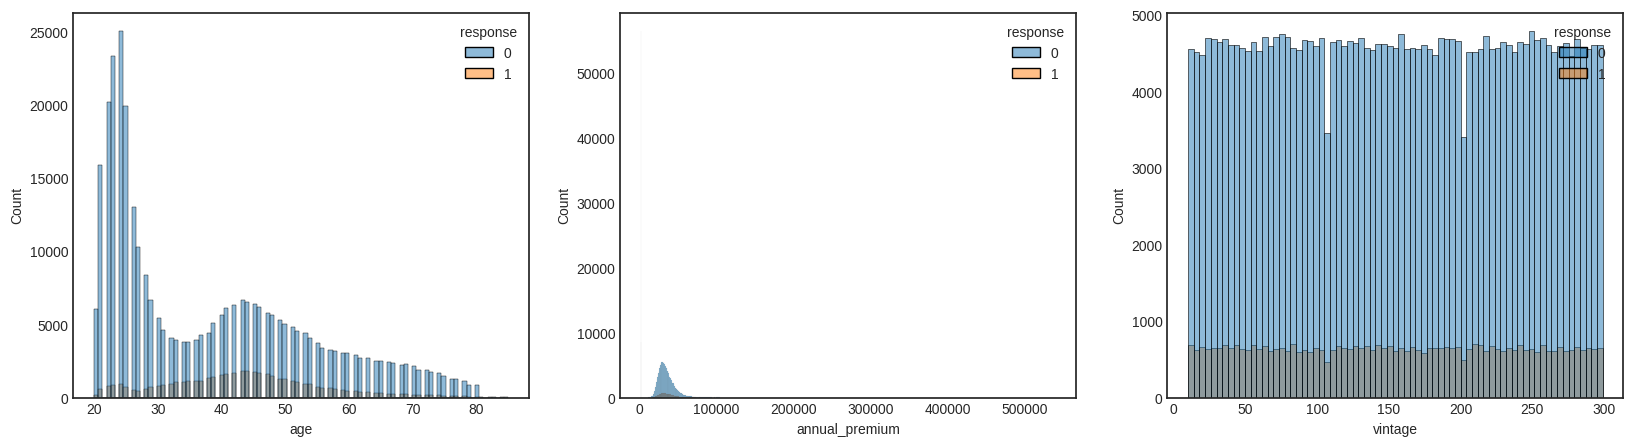

In [18]:
fig, ax = plt.subplots(1,3, figsize=(20, 5))
sns.histplot(data=df1, x=df1['age'], hue=df1['response'], ax=ax[0])
sns.histplot(data=df1, x=df1['annual_premium'], hue=df1['response'], ax=ax[1])
sns.histplot(data=df1, x=df1['vintage'], hue=df1['response'], ax=ax[2])

In [18]:
save_interim(df1, 'df2.csv')

### 1.4.3. Target variable

In [19]:
df1[['response']].value_counts(normalize=True)

response
0           0.877437
1           0.122563
Name: proportion, dtype: float64

<Axes: xlabel='response', ylabel='count'>

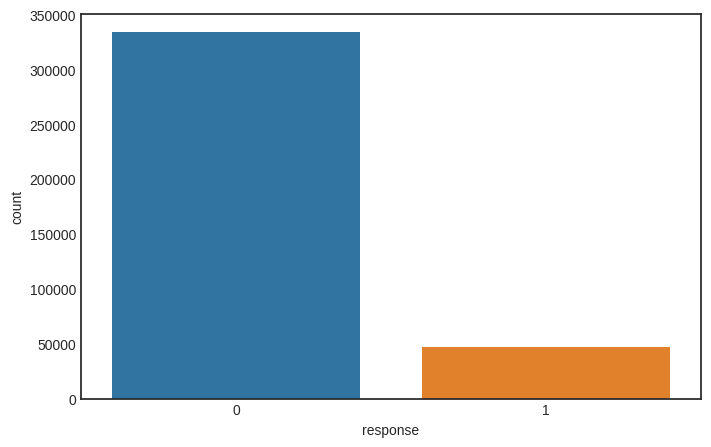

In [20]:
plt.figure(figsize=(8,5))
sns.countplot(data=df1, x=df1['response'])

**Summary**
- Response is **unbalanced**
    * 87,74% wouldn't be interested
    * 12,26% would be interested

# 2. Feature Engeneering

In [21]:
df1['vehicle_age'] = df1['vehicle_age'].apply(lambda x: 'over_2_years' if x == '> 2 Years' else
                                              'between_1_2_years' if x == '1-2 Year' else
                                              'below_1_year')

df1['vehicle_damage'] = df1['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)

In [22]:
df1.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,Male,44,1,28.0,0,over_2_years,1,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,between_1_2_years,0,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,over_2_years,1,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,below_1_year,0,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,below_1_year,0,27496.0,152.0,39,0


In [23]:
save_interim(df1, 'df3.csv')

# 3. Data Filtering

# 4. Exploratory Data Analysis (EDA)

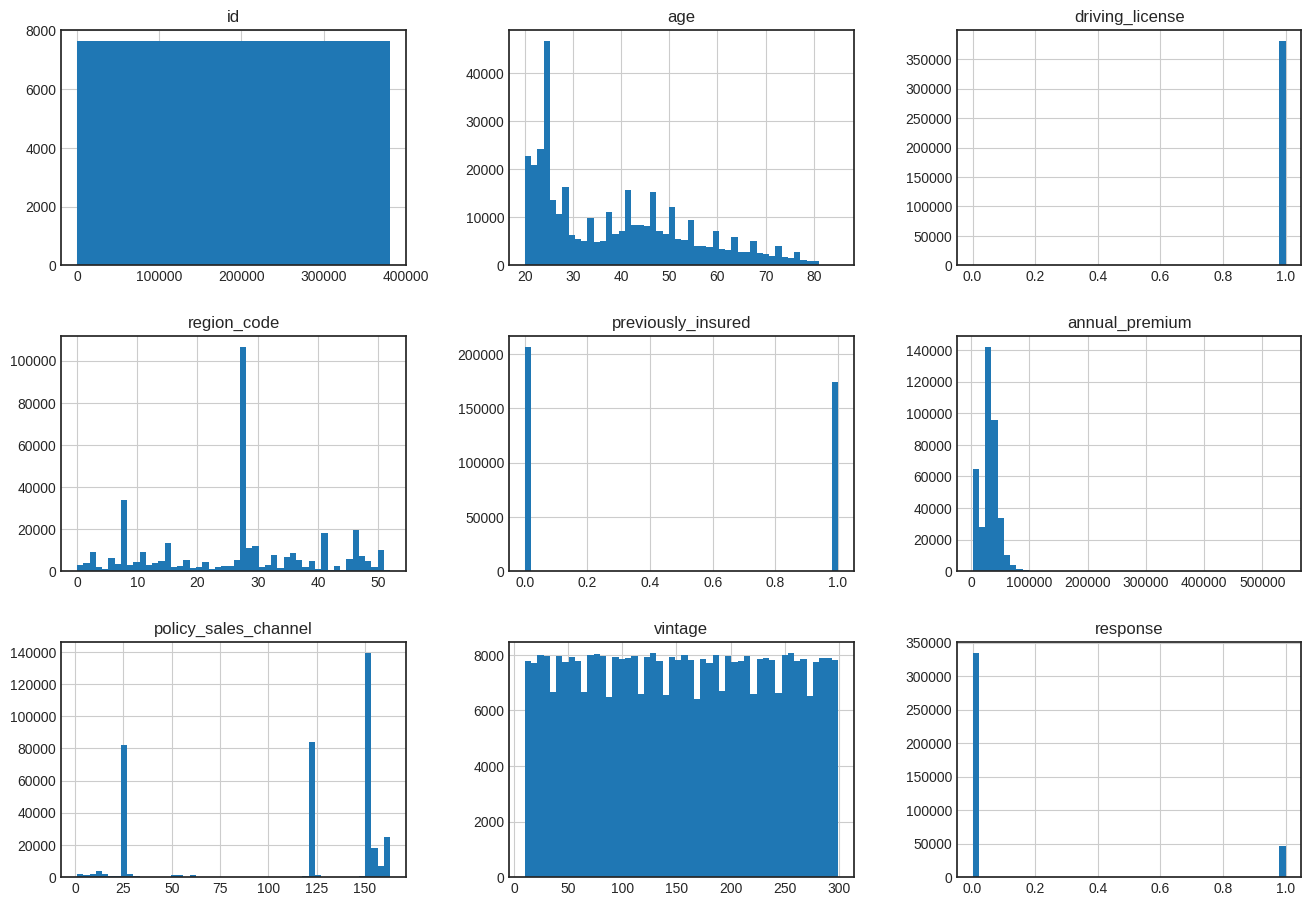

In [25]:
num_attributes.hist(bins=50, figsize=(16,11));

/home/ezequiel/.pyenv/versions/HICS/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


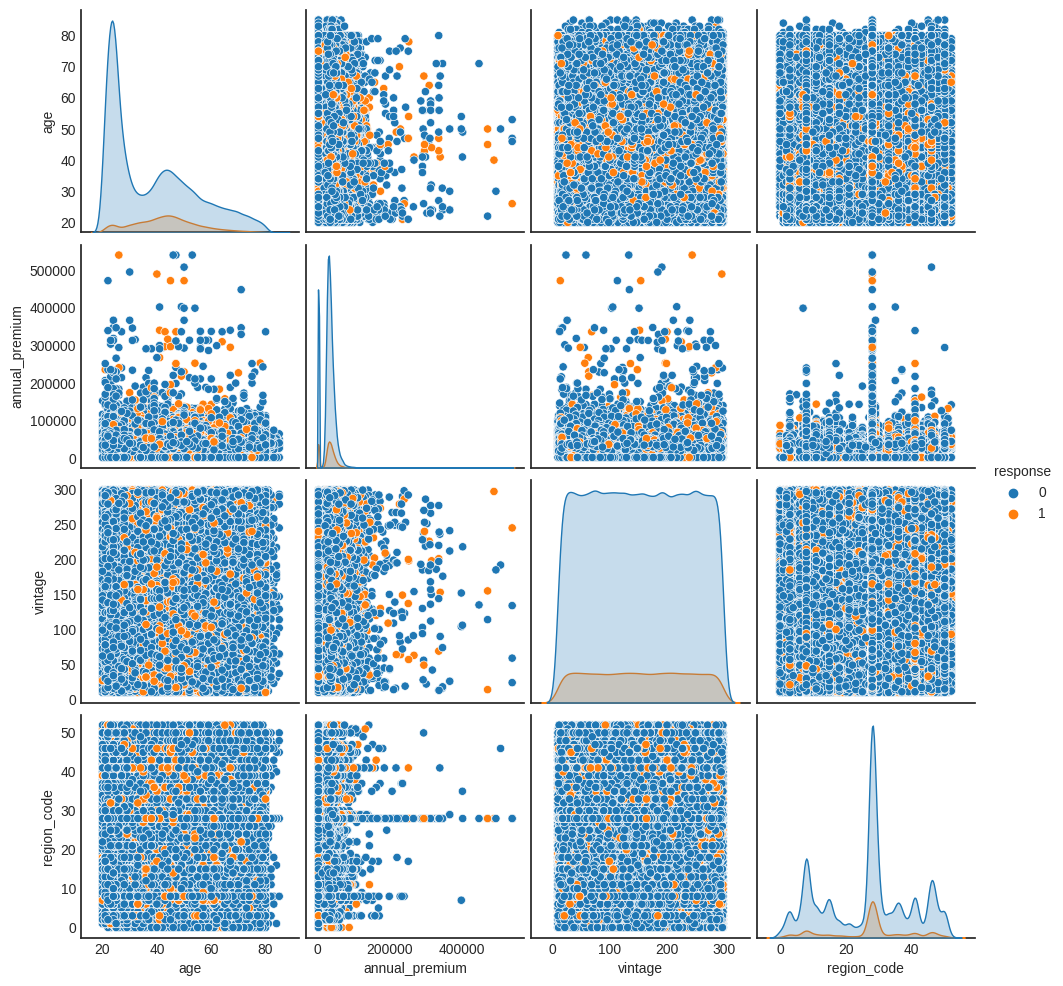

In [26]:
sns.pairplot(data=df1, vars=['age', 'annual_premium', 'vintage', 'region_code'], hue='response')
plt.show()

**Summary**
- Individuals with lower ages would not be interested in health insurace
- There is no clear correlation

## 4.1. Hypothesis

Columns description:

* **id**                      Unique ID for the customer  
* **Gender**                  Gender of the customer  
* **Age**                     Age of the customer  
* **Driving_License**         0 : Customer does not have DL, 1 : Customer already has DL  
* **Region_Code** 	        Unique code for the region of the customer  
* **Previously_Insured**	    1 : Customer already has Vehicle Insurance, 0 : Customer doesn't have Vehicle Insurance  
* **Vehicle_Age** 	        Age of the Vehicle  
* **Vehicle_Damage** 	        1 : Customer got his/her vehicle damaged in the past. 0 : Customer didn't get his/her vehicle damaged in the past.  
* **Annual_Premium** 	        The amount customer needs to pay as premium in the year  
* **Policy_Sales_Channel** 	Anonymized Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc.  
* **Vintage** 	            Number of Days which customer has been associated with the company  
* **Response** 	            1 : Customer is interested, 0 : Customer is not interested

Currency: Idian Rupee (Rs)

- **H1**: Individuals with more than 30 years would be interested in health insurance.
- **H2**: Women would be more interested in having health insurance.
- **H3**: Individuals who already have driving license and got the vehicle damage in the past would be more interested in health insurance.
- **H4**: Individuals who already have vehicle insurance (previously insured) would be more interested in health insurance.
- **H5**: Individuals who got the vehicle damaged and are previously insuded would be more interested in health insurance.
- **H6**: Individuals who own vehicle with less than one year would be more interested in health insurance.
- **H7**: Individuals who own vehicle with more than two year would be more interested in health insurance.

## 4.2. Univariate Analisys

### 4.1.1. Age

<Axes: xlabel='age', ylabel='Count'>

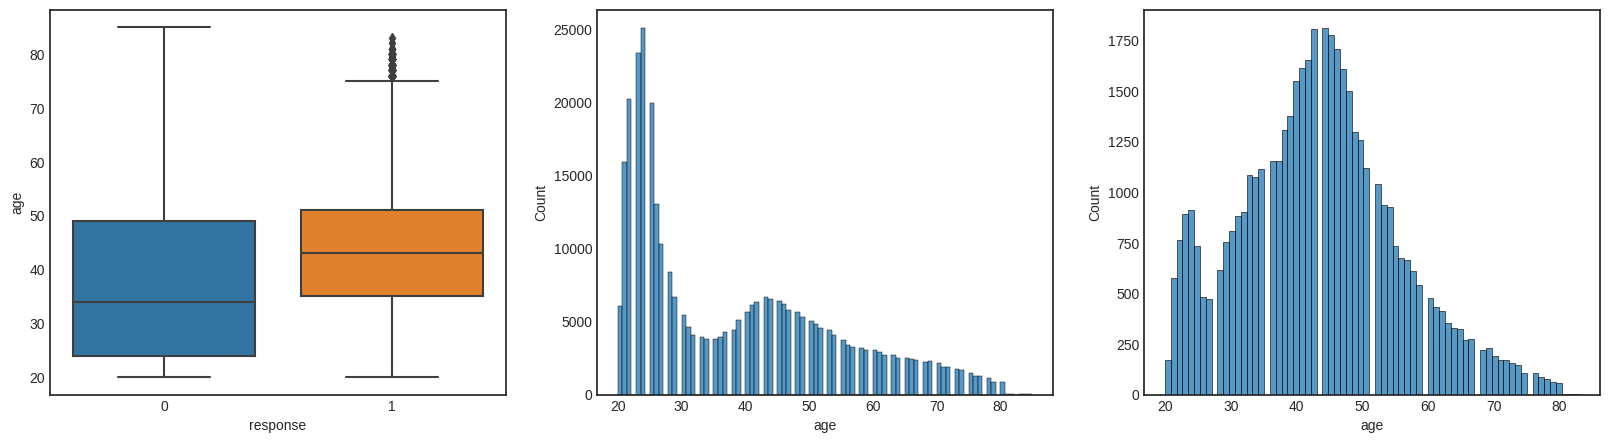

In [24]:
# age
fig, ax = plt.subplots(1,3, figsize=(20, 5))
sns.boxplot(ax=ax[0], x='response', y='age', data=df1)
sns.histplot(df1.loc[df1['response'] == 0, 'age'], ax=ax[1])
sns.histplot(df1.loc[df1['response'] == 1, 'age'], ax=ax[2])
#ax[1].hist(df1.loc[df1['response'] == 0, 'age'])

#### **H1**: Individuals with more than 30 years would be interested in health insurance.

In [25]:
aux0 = pd.DataFrame(df1.query('age > 20')['response'].value_counts(normalize=True)).reset_index().rename(columns={'proportion': 'age > 20'})
aux0['age > 30'] = pd.DataFrame(df1.query('age > 30')['response'].value_counts(normalize=True)).reset_index()[['proportion']]
aux0['age > 40'] = pd.DataFrame(df1.query('age > 40')['response'].value_counts(normalize=True)).reset_index()[['proportion']]
aux0['age > 50'] = pd.DataFrame(df1.query('age > 50')['response'].value_counts(normalize=True)).reset_index()[['proportion']]
aux0['age > 60'] = pd.DataFrame(df1.query('age > 60')['response'].value_counts(normalize=True)).reset_index()[['proportion']]

In [26]:
aux0

,response,age > 20,age > 30,age > 40,age > 50,age > 60
0,0,0.875855,0.820044,0.830197,0.865547,0.90312
1,1,0.124145,0.179956,0.169803,0.134453,0.09688


<Axes: xlabel='response', ylabel='count'>

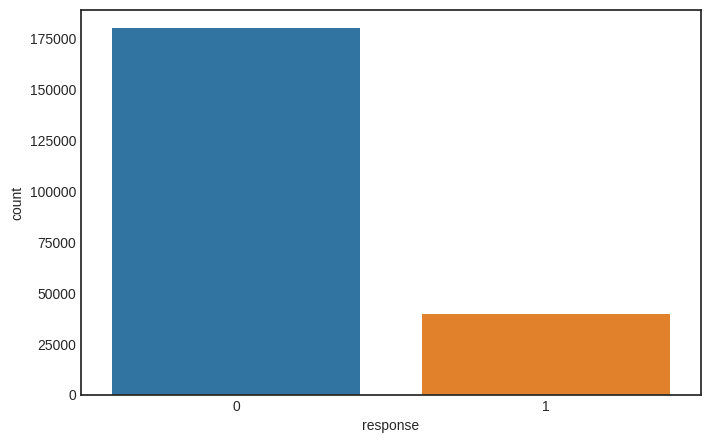

In [27]:
plt.figure(figsize=(8,5))
sns.countplot(data=df1.query('age > 30'), x=df1.query('age > 30')['response'])

**H1** is FALSE. Only about 18% of people older than 30 years are interested in health insurance
- OBS.: This proportion decreases when the age is increased.

### 4.1.2. Gender

#### **H2**: Women would be more interested in having health insurance.

In [28]:
gender_count = pd.crosstab(df1['response'], df1['gender'])
gender_count

gender,Female,Male
response,,
0,156835,177564
1,18185,28525


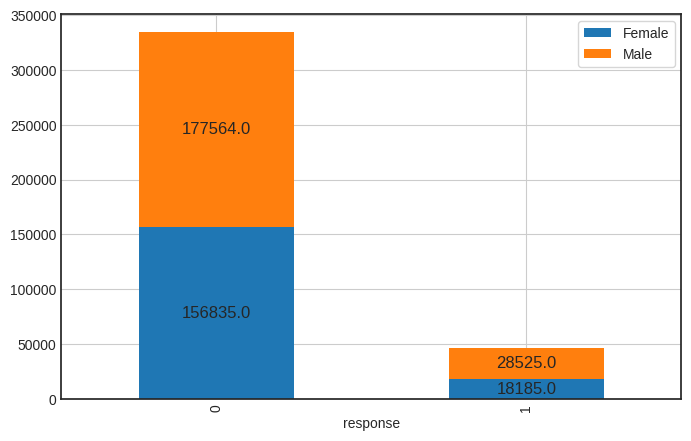

In [29]:
fig, ax = plt.subplots(figsize=(8,5))
gender_count.plot(kind='bar', stacked=True, ax=ax)
ax.grid()
ax.legend(frameon=True)
for c in ax.containers:
    labels = [str(round(v.get_height(), 2)) if v.get_height() > 0 else '' for v in c]
    ax.bar_label(c,
                 label_type='center',
                 labels = labels,
                 size = 12)

In [30]:
# Values normalized by total of M and F
pd.crosstab(df1['response'], df1['gender'], normalize='columns')

gender,Female,Male
response,,
0,0.896098,0.861589
1,0.103902,0.138411


**H2** is FALSE. 10,4% of total women are interested compared to 13,8% of total men.

### 4.1.3. Previously Insured

#### **H4**: Individuals who already have vehicle insurance (previously insured) would be more interested in health insurance.

In [31]:
# previously_insured
pd.crosstab(df1['previously_insured'], df1['response'], normalize='index')      # normalizar pelo index retorna o percentual da coluna sobre o total de cada linha

# previously_insured praticamente replica a variável resposta.

response,0,1
previously_insured,,
0,0.774546,0.225454
1,0.999095,0.000905


**H4** is FALSE. Almost everyone who has vehicle insurance are not interestes in health insurance

### 4.1.4. Vehicle Age

#### **H6**: Individuals who own vehicle with less than one year would be more interested in health insurance.
#### **H7**: Individuals who own vehicle with more than two year would be more interested in health insurance.

In [32]:
aux = pd.crosstab(df1['response'], df1['vehicle_age'])
aux

vehicle_age,below_1_year,between_1_2_years,over_2_years
response,,,
0,157584,165510,11305
1,7202,34806,4702


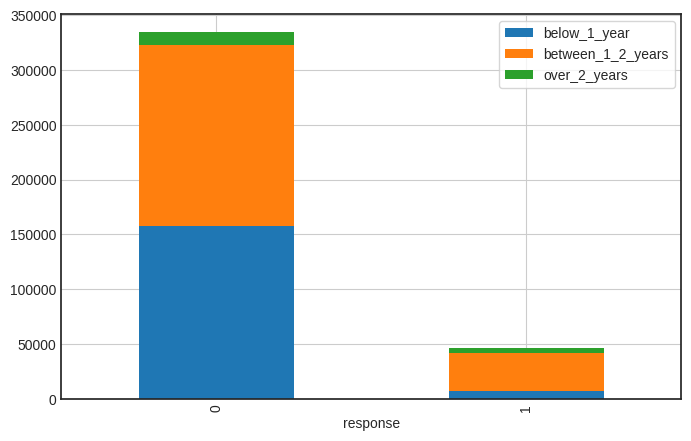

In [33]:
fig, ax = plt.subplots(figsize=(8,5))
aux.plot(kind='bar', stacked=True, ax=ax)
ax.legend(frameon=True)
ax.grid()

**H6** and **H7** is FALSE. Ownners of vehicles between 1-2 years are the most interested.

In [34]:
# vehicle_age
df1[['vehicle_age', 'response']].value_counts(normalize=True, sort=False).reset_index()

,vehicle_age,response,proportion
0,below_1_year,0,0.413488
1,below_1_year,1,0.018897
2,between_1_2_years,0,0.434285
3,between_1_2_years,1,0.091328
4,over_2_years,0,0.029663
5,over_2_years,1,0.012338


### 4.1.5. Annual Premium

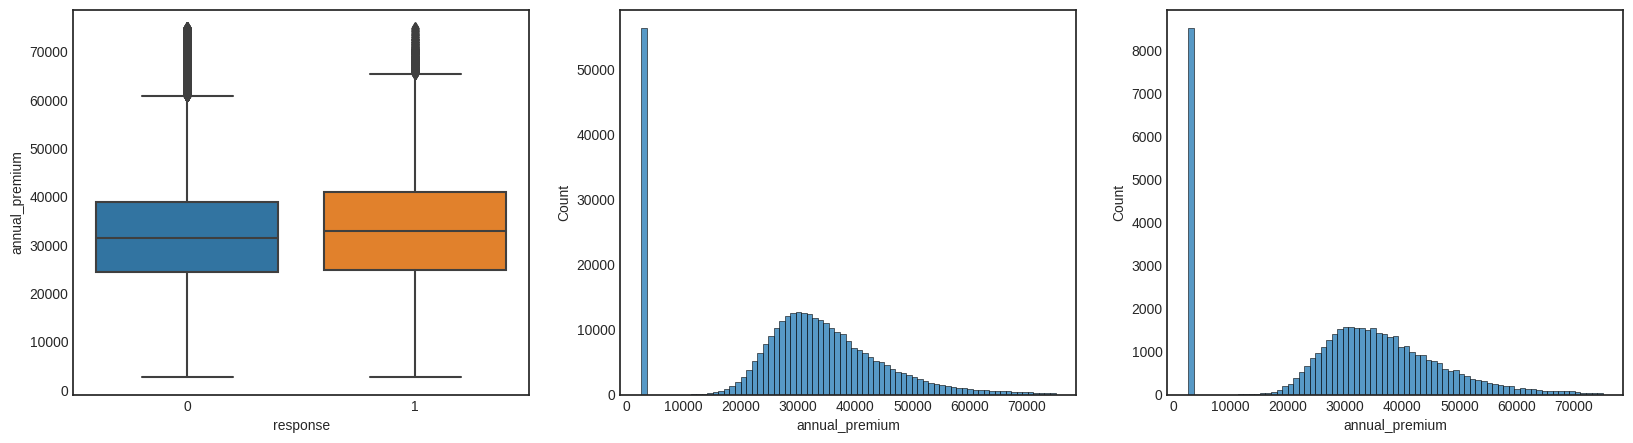

In [35]:
# annual_premium
start_at = 2000
end_at = 75000

fig, ax = plt.subplots(1,3, figsize=(20, 5))
sns.boxplot(ax=ax[0], x='response', y='annual_premium', data=df1.loc[df1['annual_premium'] < end_at])
sns.histplot(df1.loc[(df1['response'] == 0) & (df1['annual_premium'] > start_at) & (df1['annual_premium'] < end_at), 'annual_premium'], bins=75, ax=ax[1])
sns.histplot(df1.loc[(df1['response'] == 1) & (df1['annual_premium'] > start_at) & (df1['annual_premium'] < end_at), 'annual_premium'], bins=75, ax=ax[2]);

# Pelo boxplot, aparentemente, não há distinção entre as distribuições das classes de response quando se compara annual_premium

### 4.1.3. Driving License

In [36]:
# driving_license
df1[['driving_license', 'response']].value_counts().reset_index()

,driving_license,response,count
0,1,0,333628
1,1,1,46669
2,0,0,771
3,0,1,41


In [37]:
df1.query('driving_license == 1')['response'].value_counts(normalize=True).reset_index()

,response,proportion
0,0,0.877283
1,1,0.122717


Only 12,27% of people who posses driver license are interested in health insurance

### 4.1.4. Region Code

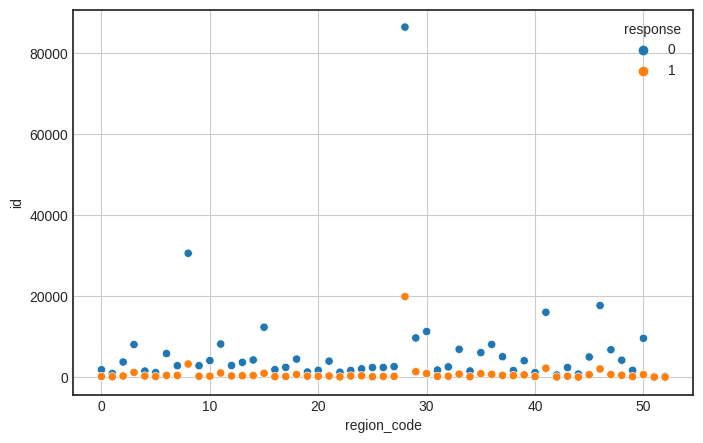

In [38]:
# region_code
aux = df1[['id', 'region_code', 'response']].groupby(['region_code', 'response']).count().reset_index()

plt.figure(figsize=(8,5))
sns.scatterplot(data=aux, x='region_code', y='id', hue='response')
plt.grid()

# region_code, aparentemente, não é capaz de explicar response

### 4.1.7. Policy Sales Channel

In [39]:
# policy_sales_channel

aux = pd.crosstab(df1['policy_sales_channel'], df1['response'], normalize='index')

<Axes: xlabel='policy_sales_channel'>

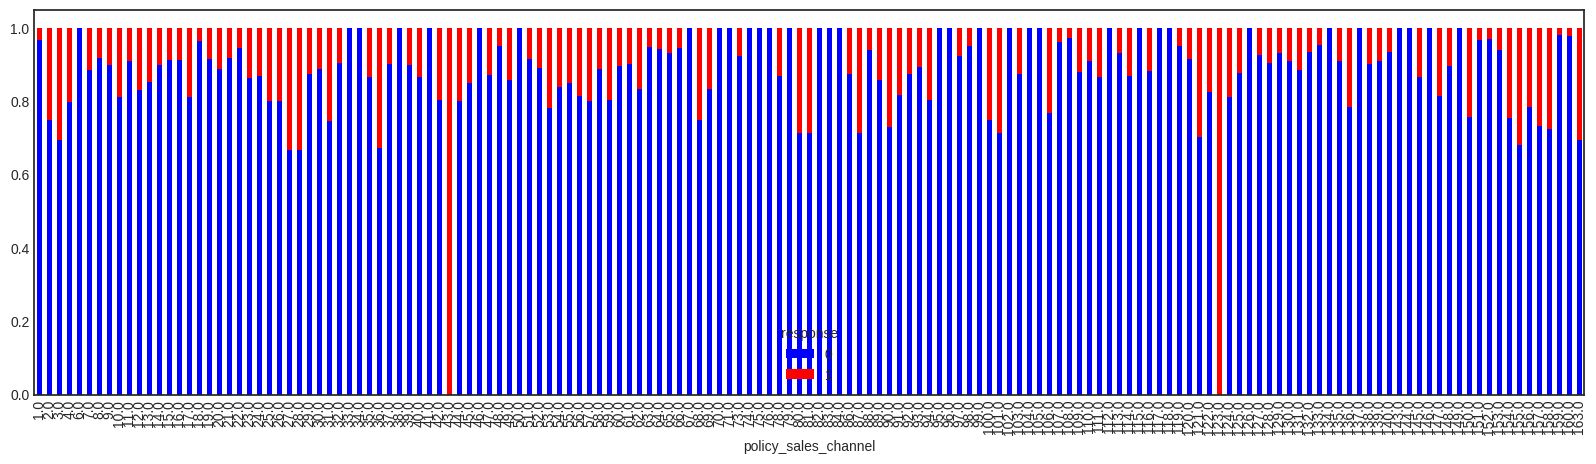

In [40]:
aux.plot(kind='bar', stacked=True, figsize=(20,5), colormap='bwr')

### 4.1.8. Vintage

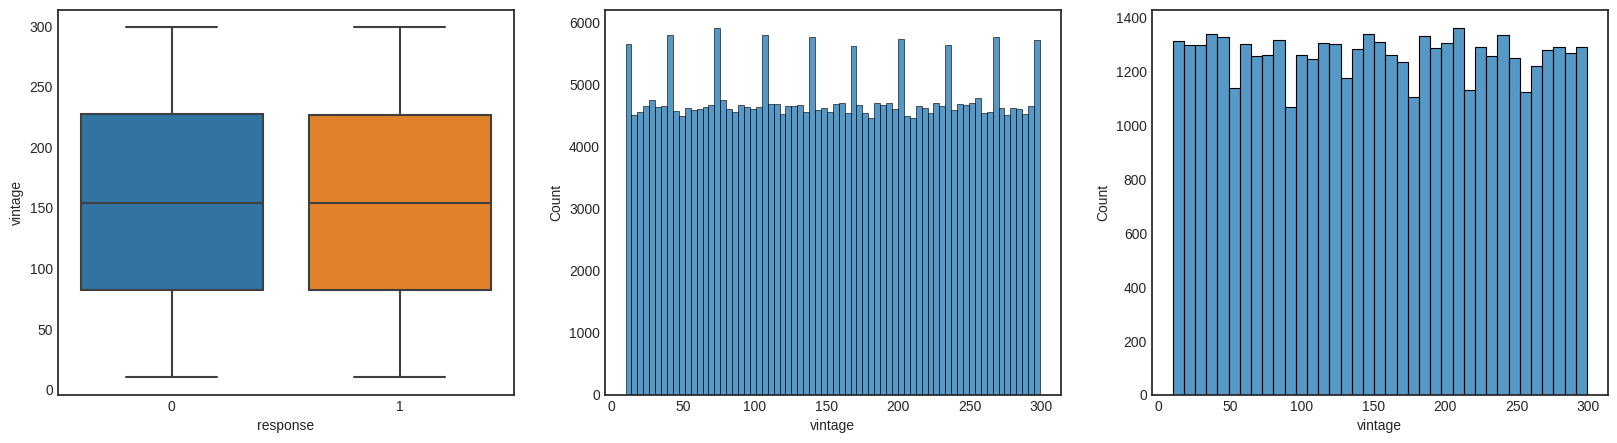

In [41]:
# vintage

fig, ax = plt.subplots(1,3, figsize=(20, 5))
sns.boxplot(ax=ax[0], x='response', y='vintage', data=df1)
sns.histplot(df1.loc[df1['response'] == 0, 'vintage'], ax=ax[1])
sns.histplot(df1.loc[df1['response'] == 1, 'vintage'], ax=ax[2]);

## 4.3. Bivariate Analysis

#### **H3**: Individuals who already have driving license and got the vehicle damage in the past would be more interested in health insurance.

In [42]:
df1.groupby(['driving_license', 'vehicle_damage'])['response'].value_counts().reset_index()

,driving_license,vehicle_damage,response,count
0,0,0,0,256
1,0,1,0,515
2,0,1,1,41
3,1,0,0,187458
4,1,0,1,982
5,1,1,0,146170
6,1,1,1,45687


**H3** is FALSE. 

#### **H5**: Individuals who got the vehicle damaged and has vehicle insurance (previously insured) would be more interested in health insurance.

In [43]:
df1.groupby(['vehicle_damage', 'previously_insured'])['response'].value_counts().reset_index()

,vehicle_damage,previously_insured,response,count
0,0,0,0,23080
1,0,0,1,910
2,0,1,0,164634
3,0,1,1,72
4,1,0,0,136849
5,1,0,1,45642
6,1,1,0,9836
7,1,1,1,86


**H5** is FALSE. Individuals who already got vehicle damage and already have vehicle insurance do not want another insurance

In [44]:
cat_attributes['gender'].value_counts()
# Man: 54,08%
# Woman: 45,92%

gender
Male      206089
Female    175020
Name: count, dtype: int64

In [45]:
pd.DataFrame(cat_attributes.groupby('gender')['vehicle_age'].value_counts(sort=False))

count
gender vehicle_age        
Female 1-2 Year      77992
       < 1 Year      91321
       > 2 Years      5707
Male   1-2 Year     122324
       < 1 Year      73465
       > 2 Years     10300

In [46]:
pd.DataFrame(cat_attributes.groupby('vehicle_age')['gender'].value_counts(normalize=True, sort=False))

proportion
vehicle_age gender            
1-2 Year    Female    0.389345
            Male      0.610655
< 1 Year    Female    0.554179
            Male      0.445821
> 2 Years   Female    0.356532
            Male      0.643468

<Axes: xlabel='vehicle_age', ylabel='count'>

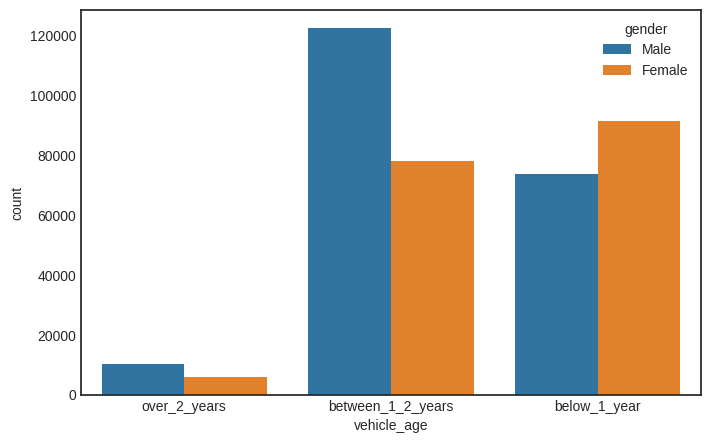

In [47]:
plt.figure(figsize=(8,5))
sns.countplot(data=df1, x=df1['vehicle_age'], hue=df1['gender'])

Number of women using cars are increasing. Cars wits < 1 year are mostly used by women

In [48]:
cat_attributes.groupby('gender')['vehicle_damage'].value_counts(sort=False)

gender  vehicle_damage
Female  No                 95355
        Yes                79665
Male    No                 93341
        Yes               112748
Name: count, dtype: int64

<Axes: xlabel='vehicle_damage', ylabel='count'>

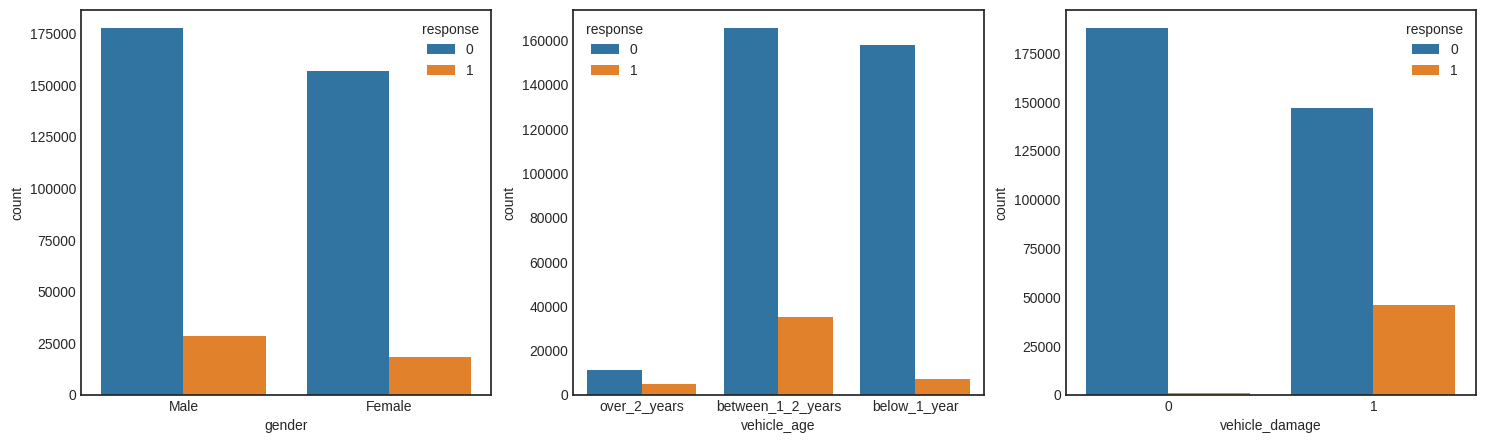

In [49]:
fig, ax = plt.subplots(1,3, figsize=(18,5))
sns.countplot(data=df1, x=df1['gender'], hue=df1['response'], ax=ax[0])
sns.countplot(data=df1, x=df1['vehicle_age'], hue=df1['response'], ax=ax[1])
sns.countplot(data=df1, x=df1['vehicle_damage'], hue=df1['response'], ax=ax[2])

# 5. Data Preparation

In [50]:
df1.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,Male,44,1,28.0,0,over_2_years,1,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,between_1_2_years,0,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,over_2_years,1,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,below_1_year,0,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,below_1_year,0,27496.0,152.0,39,0


**Numercial variables**
- driving license -> 0 or 1, represents cat attribute
- previously insured -> 0 or 1, represents cat attribute
- response -> 0 or 1, represents cat attribute
- age -> not normal distribution (Chi-squared? Poissson?)
- annual premium -> similar to a log-normal distribution (or just a normal distribution)
- vintage -> low kurtosis, uniform distribution
- region code -> does not follow any specific distribution
- policy sales channel -> same as region code

## 5.1. Spliting data into trainning and validation

In [51]:
# Separando os dados entre treino (80%) e validação (20%)
df1_train, df1_val = train_test_split(df1, test_size=0.2, stratify=df1['response'], random_state=seed)

X_val = df1_val.drop('response', axis=1)
y_val = df1_val['response']

save_interim(df1_train, 'df1_train.csv')
save_interim(X_val, 'X_val.csv')
save_interim(y_val, 'y_val.csv')

## 5.2. Standardization

- Makes the distribution fits a normal distribution with mean equal to zero
- Suitable for data similar to normal distribution

In [3]:
#df1_train = load_interim('df1_train.csv.zip')
#sns.histplot(data=df1_train, x=df1_train['annual_premium'], bins=200)

In [5]:
# annual_premiuim
#std_scaler = PowerTransformer()
std_scaler = StandardScaler()

df1_train['annual_premium'] = std_scaler.fit_transform(df1_train[['annual_premium']])

<Axes: xlabel='annual_premium', ylabel='Count'>

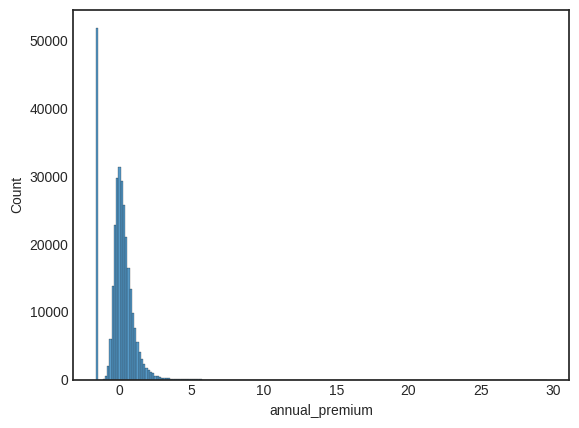

In [6]:
sns.histplot(data=df1_train, x=df1_train['annual_premium'], bins=200)

In [79]:
pickle.dump(std_scaler, open('../models/annual_premium_feature.pkl', 'wb'))

## 5.3. Rescaling

- Makes the data vary from 0 to 1
- When data do not fit a normal distribution

In [ ]:
#fig, ax = plt.subplots(1,2, figsize=(16,5))
#sns.histplot(data=df1_train, x=df1_train['age'], bins=100, ax=ax[0])
#sns.histplot(data=df1_train, x=df1_train['vintage'], bins=100, ax=ax[1])

In [7]:
# age
mms_age = MinMaxScaler()
df1_train['age'] = mms_age.fit_transform(df1_train[['age']])

# vintage
mms_vintage = MinMaxScaler()
df1_train['vintage'] = mms_vintage.fit_transform(df1_train[['vintage']])

<Axes: xlabel='vintage', ylabel='Count'>

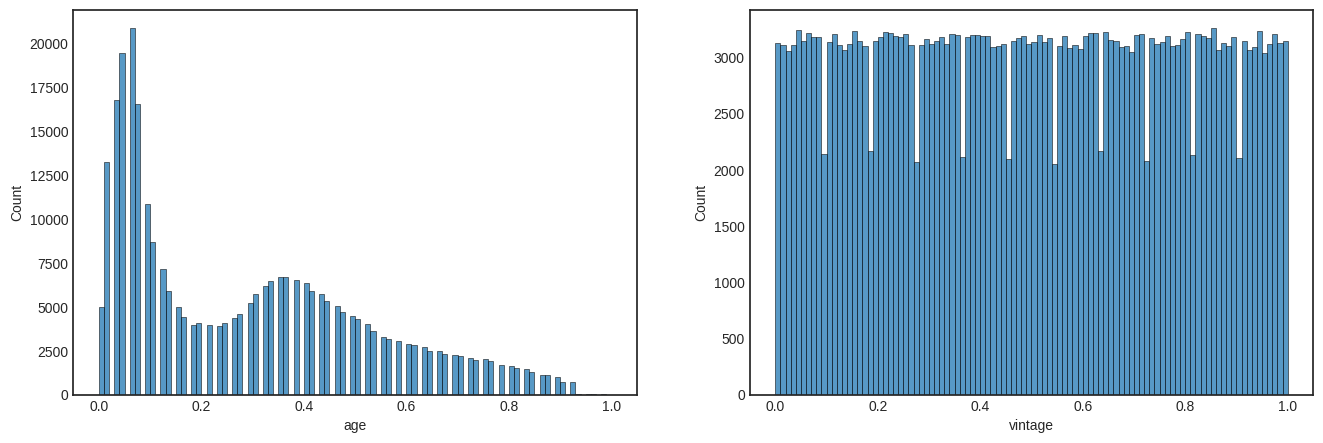

In [8]:
fig, ax = plt.subplots(1,2, figsize=(16,5))
sns.histplot(data=df1_train, x=df1_train['age'], bins=100, ax=ax[0])
sns.histplot(data=df1_train, x=df1_train['vintage'], bins=100, ax=ax[1])

In [111]:
pickle.dump(mms_age, open('../models/age_feature.pkl', 'wb'))
pickle.dump(mms_vintage, open('../models/vintage_feature.pkl', 'wb'))

In [9]:
save_interim(df1_train, 'df2_train.csv')

## 5.4. Encoder

- Transform categorical attributes to numerical ones

In [105]:
#df1_train = load_interim('df2_train.csv.zip')

In [106]:
# region_code - target encoder
# Why do not use frequency encoding?
tar_enc_region_code = TargetEncoder(random_state=seed)
df1_train['region_code'] = tar_enc_region_code.fit_transform(df1_train[['region_code']], df1_train['response'])

<Axes: xlabel='region_code', ylabel='Count'>

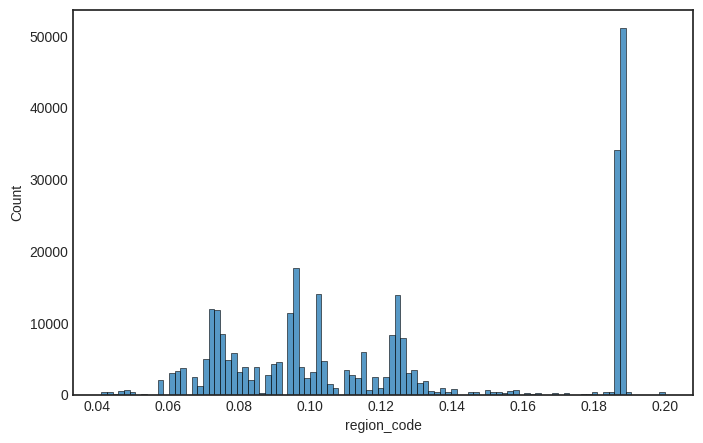

In [107]:
plt.figure(figsize=(8,5))
sns.histplot(data=df1_train, x=df1_train['region_code'], bins=100)

In [108]:
# gender
#tar_enc_gender = TargetEncoder()
#df1_train['gender'] = tar_enc_gender.fit_transform(df1_train[['gender']], df1_train['response'])

ohe_gender = OneHotEncoder()
gender = ohe_gender.fit_transform(df1_train[['gender']]).toarray()
df1_train[list(map(str.lower, ohe_gender.categories_[0]))] = gender
df1_train.drop('gender', axis=1, inplace=True)
#df1_train.columns = df1_train.columns.str.lower()

In [110]:
# vehicle_age - one hot encoder
ohe_vehicle_age = OneHotEncoder()
vehicle_age_encoded = ohe_vehicle_age.fit_transform(df1_train[['vehicle_age']]).toarray()
df1_train[ohe_vehicle_age.get_feature_names_out()] = vehicle_age_encoded
df1_train.drop('vehicle_age', axis=1, inplace=True)

In [111]:
# policy_sales_channel - frequency enconder
fe_policy_sales_channel = df1_train.groupby('policy_sales_channel').size() / len(df1_train)
df1_train.loc[:, 'policy_sales_channel'] = df1_train['policy_sales_channel'].map(fe_policy_sales_channel)

<Axes: xlabel='policy_sales_channel', ylabel='Count'>

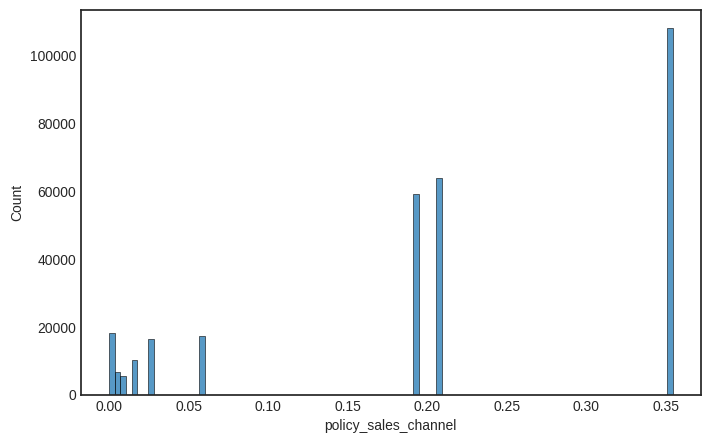

In [112]:
plt.figure(figsize=(8,5))
sns.histplot(data=df1_train, x=df1_train['policy_sales_channel'], bins=100)

In [113]:
df1_train.head()

,id,age,driving_license,region_code,previously_insured,vehicle_damage,annual_premium,policy_sales_channel,vintage,response,female,male,vehicle_age_below_1_year,vehicle_age_between_1_2_years,vehicle_age_over_2_years
0,274711,0.030769,1,0.111934,0,1,-0.297943,0.354223,0.667820,0,0.0,1.0,1.0,0.0,0.0
1,216540,0.092308,1,0.096747,1,0,0.452554,0.208959,0.121107,0,1.0,0.0,1.0,0.0,0.0
2,78984,0.184615,1,0.187705,0,1,0.088559,0.026079,0.086505,1,1.0,0.0,1.0,0.0,0.0
3,218369,0.184615,1,0.077901,0,1,0.412993,0.354223,0.709343,0,0.0,1.0,1.0,0.0,0.0
4,307216,0.061538,1,0.186392,0,1,1.050781,0.027787,0.733564,0,1.0,0.0,1.0,0.0,0.0


In [114]:
pickle.dump(ohe_gender, open('../models/gender_feature.pkl', 'wb'))
pickle.dump(tar_enc_region_code, open('../models/region_code_feature.pkl', 'wb'))
pickle.dump(ohe_vehicle_age, open('../models/vehicle_age_feature.pkl', 'wb'))
pickle.dump(fe_policy_sales_channel, open('../models/policy_sales_channel_feature.pkl', 'wb'))

In [115]:
save_interim(df1_train, 'df3_train.csv')

## 5.5. Validation Pipeline

In [116]:
#std_scaler = pickle.load(open('../models/annual_premium_feature.pkl', 'rb'))
#mms_age = pickle.load(open('../models/age_feature.pkl', 'rb'))
#mms_vintage = pickle.load(open('../models/vintage_feature.pkl', 'rb'))
#
#X_val = load_interim('X_val.csv.zip')

In [117]:
# Perform only transformation

X_val['annual_premium'] = std_scaler.transform(X_val[['annual_premium']])

X_val['age'] = mms_age.transform(X_val[['age']])

X_val['vintage'] = mms_vintage.transform(X_val[['vintage']])

X_val['region_code'] = tar_enc_region_code.transform(X_val[['region_code']])

X_val_ohe_gender = ohe_gender.transform(X_val[['gender']]).toarray()
X_val[list(map(str.lower, ohe_gender.categories_[0]))] = X_val_ohe_gender

X_val_vehicle_age_encoded = ohe_vehicle_age.transform(X_val[['vehicle_age']]).toarray()
X_val[ohe_vehicle_age.get_feature_names_out()] = X_val_vehicle_age_encoded

X_val.drop(['gender', 'vehicle_age'], axis=1, inplace=True)

X_val.loc[:, 'policy_sales_channel'] = X_val['policy_sales_channel'].map(fe_policy_sales_channel)

In [118]:
X_val.dropna(inplace=True)

In [119]:
X_val.info()

<class 'pandas.core.frame.DataFrame'>
Index: 76221 entries, 0 to 76221
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             76221 non-null  int64  
 1   age                            76221 non-null  float64
 2   driving_license                76221 non-null  int64  
 3   region_code                    76221 non-null  float64
 4   previously_insured             76221 non-null  int64  
 5   vehicle_damage                 76221 non-null  int64  
 6   annual_premium                 76221 non-null  float64
 7   policy_sales_channel           76221 non-null  float64
 8   vintage                        76221 non-null  float64
 9   female                         76221 non-null  float64
 10  male                           76221 non-null  float64
 11  vehicle_age_below_1_year       76221 non-null  float64
 12  vehicle_age_between_1_2_years  76221 non-null  floa

# 6. Feature Selection

<Axes: >

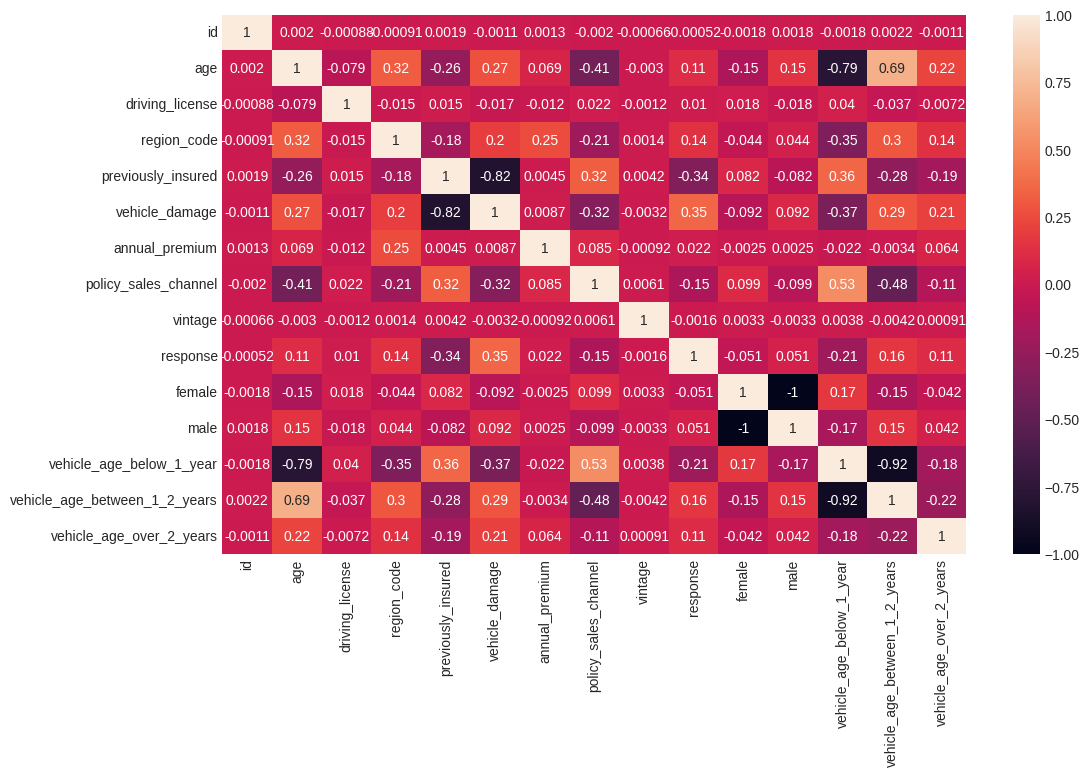

In [120]:
corr_matrix = df1_train.corr(method='pearson')

plt.figure(figsize=(12,7))
sns.heatmap(corr_matrix, annot=True)

## 6.1. Feature importance

- A partir de um modelo se busca encontrar as importâncias de cada feature para o dado modelo

In [ ]:
# Treino do modelo
X_train_n = df1_train.drop(['id', 'response'], axis=1)
y_train_n = df1_train['response']

etree_clf = ExtraTreesClassifier(n_estimators=150, random_state=0, n_jobs=-1)
etree_clf.fit(X_train_n, y_train_n)

In [ ]:
skplt.estimators.plot_feature_importances(etree_clf, feature_names=X_train_n.columns, figsize=(12,5), x_tick_rotation=60)

In [ ]:
np.sort(etree_clf.feature_importances_)[::-1]

## 6.2. Boruta

In [ ]:
#boruta_selector = BorutaPy(estimator=etree_clf, n_estimators='auto', verbose=2, random_state=42)
#boruta_selector.fit(X_train_n.values, y_train_n.values.ravel())

In [ ]:
#X_train_n.loc[:, boruta_selector.support_]

# 7. Machine Learing

In [ ]:
selected_features = ['vintage', 'annual_premium', 'region_code', 'age', 'gender', 'vehicle_damage', 'policy_sales_channel', 'previously_insured']

# x_train = df1_train[selected_features]
# x_val = X_val[selected_features]

## 7.1. Teste com KNN

In [ ]:
# Definição e treino do modelo
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(df1_train[selected_features], df1_train[['response']])

# Predição - poder de GENERALIZAÇÃO
yhat_knn = knn_model.predict_proba(X_val[selected_features])

In [ ]:
skplt.metrics.plot_cumulative_gain(y_true=y_val, y_probas=yhat_knn)
# Se 25% (Percentage of sample) das pessoas da lista ordenada forem abordadas, 63% (Gain) dos interessados serão aboradados
# Aumentando o n_neighbors, a curva pode melhorar

In [ ]:
fig, ax = plt.subplots()
skplt.metrics.plot_lift_curve(y_true=y_val, y_probas=yhat_knn, ax=ax)
ax.set_xlim(0.1, 1)
ax.set_ylim(0.5, 3)

## 7.2 Teste com Logistic Regression

In [ ]:
# Definição e treino do modelo
lr_model = LogisticRegression(random_state=42)
lr_model.fit(df1_train[selected_features], df1_train[['response']])

# Predição - poder de GENERALIZAÇÃO
yhat_lr = lr_model.predict_proba(X_val[selected_features])

In [ ]:
yhat_lr[:,1]

In [ ]:
pickle.dump(lr_model, open('/home/ezequiel/Documentos/Comunidade_DS/health_insurance_cross_sell/models/linear_regression_model.pkl', 'wb'))

In [ ]:
skplt.metrics.plot_cumulative_gain(y_true=y_val, y_probas=yhat_lr)
# Se 40% (Percentage of sample) das pessoas da lista ordenada forem abordadas, 90% (Gain) dos interessados serão aboradados

In [ ]:
fig, ax = plt.subplots()
skplt.metrics.plot_lift_curve(y_true=y_val, y_probas=yhat_lr, ax=ax)
ax.set_xlim(0.1, 1)
ax.set_ylim(0.5, 3)

## 7.3. Metrics at K

In [ ]:
# Propensity score
aux = pd.concat([X_val, y_val], axis=1)
aux['score'] = yhat_knn[:, 1].tolist()

# Sort clients by propensity score
aux = aux.sort_values('score', ascending=False)

aux = aux[['id', 'response', 'score']].reset_index(drop=True)

# K lines
K = 50

# Precision Top K
aux['precision_at_k'] = aux['response'].cumsum() / (aux.index.values + 1)
precision_at_k = aux.loc[K, 'precision_at_k']
print(f'Precision @ K: {precision_at_k:.6f}')

# Recall Top K
aux['recall_at_k'] = aux['response'].cumsum() / aux['response'].sum()
recall_at_k = aux.loc[K, 'recall_at_k']
print(f'Recall @ K: {recall_at_k:.6f}')